In [ ]:
# Imports and Environment Setup

from pathlib import Path
import sys
import os
import pandas as pd

# Environment setup
import dotenv
dotenv.load_dotenv(".env", override=True) # Defines MONGO_URI

# Local
project_root = Path.cwd().parent
src_path = str(project_root / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from analysis.fetch import fetch_images, fetch_chainguard_images, global_latest_scan
from analysis.remediation import fetch_remediations, fetch_chainguard_remediations
from analysis.alpine import list_cgr_alpine
from analysis.stat import RemediationTable
from analysis.plot.hist import rtime_hist
from analysis.plot.timeline import rtime_timeline

In [2]:
# Collect Remediations

CSV_FILE = "remediations.csv"

if not os.path.exists(CSV_FILE):
    tab = fetch_remediations()
    tab._df.to_csv(CSV_FILE, index=False, escapechar="\\")

df = pd.read_csv(CSV_FILE)
df["first_seen_at"] = pd.to_datetime(df["first_seen_at"])
df["remediated_at"] = pd.to_datetime(df["remediated_at"])
tab = RemediationTable(df)

# Filter out Chainguard images based on alpine
OMIT_CSV = "omit.csv"

omit_df = pd.read_csv(OMIT_CSV)
for _, row in omit_df.iterrows():
    tab = tab.filter(repository=row["repository"],
                     purge=True)

print(f"Found {tab._df.shape[0]} scans ending on on {tab.latest_remediation()}")

/home/paul/chainguard-gallery/src/analysis/stat.py:314: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(dfs, axis=0, ignore_index=True)
/home/paul/chainguard-gallery/src/analysis/stat.py:314: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(dfs, axis=0, ignore_index=True)


Found 82535 scans ending on on 2024-06-03 02:01:47.081000


In [3]:
cgr_tab = tab.filter(registry="cgr.dev")
cgr_tab = cgr_tab.resolve_edge_cases(remediated_at=False)
n_discovered = cgr_tab.discovered().shape[0]

remediated_df = cgr_tab.remediated()
n_remediated = remediated_df.shape[0]
rtime = remediated_df["rtime"].mean()

severe_rtime = remediated_df[remediated_df["registry"] != "chainguard/mariadb"]["rtime"].mean()

print(f"N Discovered: {n_discovered}")
print(f"N Remediated: {n_remediated}")
print(f"Mean Remediation Time: {rtime / 24:.2f} days")
print(f"Mean Severe Remediation Time: {severe_rtime / 24:.2f} days")

Resolving edge-cases: 100%|██████████| 974/974 [00:00<00:00, 11344.55it/s]

N Discovered: 974
N Remediated: 887
Mean Remediation Time: 2.35 days
Mean Severe Remediation Time: 2.35 days


In [ ]:
"""
Display stats by label

Considers all CVEs seen on day 1 introduced on day 1.
"""

labels = ["docker-official", "ubi", "cgr-public"]
resolved_tab = tab.resolve_edge_cases(remediated_at=False)
for label in labels:
    label_tab = resolved_tab.filter(label=label)
    n_discovered = label_tab.discovered().shape[0]
    rem_df = label_tab.remediated()
    n_remediated = rem_df.shape[0]
    rtime = rem_df.remediated()["rtime"].mean()
    severe_rtime = rem_df[rem_df["severity"].str.isin(["critical", "high"])].mean()
    print(label + ":")
    print(f"\tDiscovered: {n_discovered}")
    print(f"\tRemediated: {n_remediated}")
    print(f"Remediation time: {rtime / 24:.2f} days") 
    print(f"Remediation time (critical + high only): {severe_rtime / 24:.2f} days")

Resolving edge-cases: 100%|██████████| 18745/18745 [00:01<00:00, 10605.35it/s]


AttributeError: 'function' object has no attribute 'shape'


KeyboardInterrupt



In [8]:
cgr_tab.residual()['id'].unique()

array(['CVE-2024-4603', 'GHSA-vg3r-rm7w-2xgh', 'CVE-2024-24787',
       'CVE-2024-24788', 'GHSA-4h8f-2wvx-gg5w', 'GHSA-m44j-cfrm-g8qc',
       'GHSA-v435-xc8x-wvr9', 'GHSA-8xfc-gm6g-vgpv',
       'GHSA-pxhw-596r-rwq5', 'GHSA-25w4-hfqg-4r52'], dtype=object)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Days', ylabel='Number of CVEs'>)

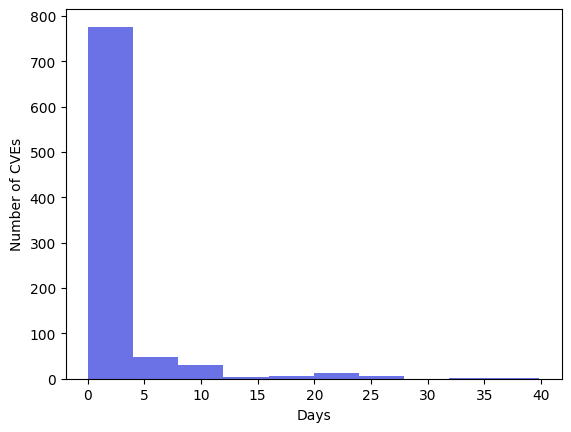

In [4]:
rtime_hist(cgr_tab)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Days', ylabel='Number of CVEs'>)

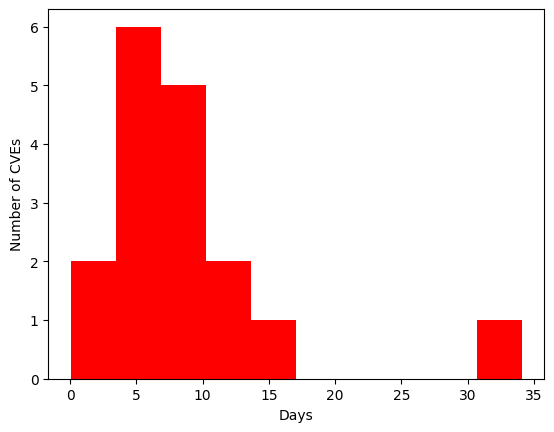

In [5]:
severe_df = cgr_tab._df.copy()
severe_df = severe_df[severe_df["severity"].isin(["critical", "high"])]
cgr_severe_tab = RemediationTable(severe_df)
rtime_hist(cgr_severe_tab, color="red")

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

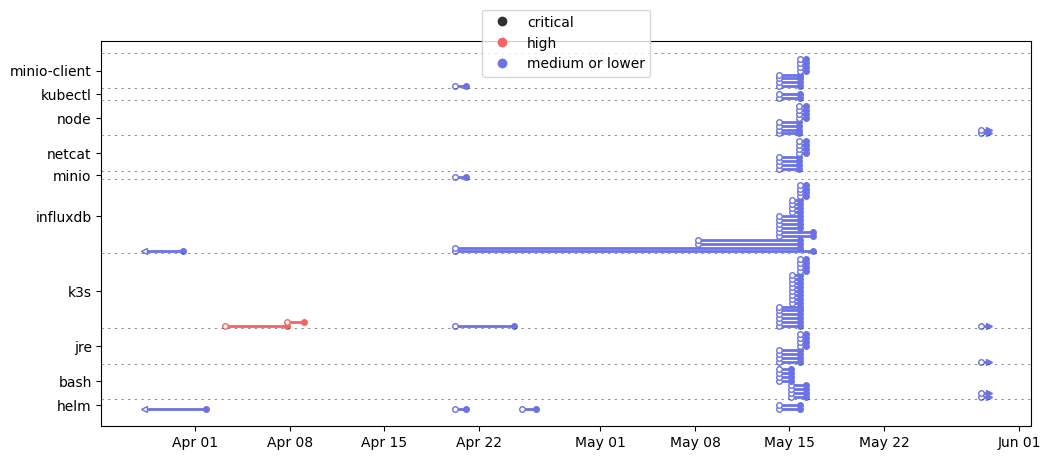

In [9]:
cgr_tab = tab.filter(label="cgr-public")
rtime_timeline(cgr_tab, figsize=(12, 5),
               include_cve_ids=False,
               max_images=10)

keycloak:
    - GHSA-f8h5-v2vg-46rr (CVE-2024-2700)
        > published 15 days ago
        > fixed 6 hours ago